# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Задача: Построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Рассматриваю распределение выборки по годам рождения

<AxesSubplot:>

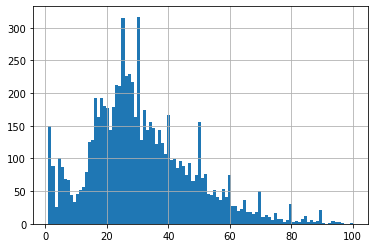

In [3]:
labels['real_age'].hist(bins=100)

Наибольшая возрастная группа - 20-30 лет. В выборке представлены все возрастные группы до 100 лет. Отмечу также большое количество детей - 5 по объему возростная группа.

In [5]:
labels.groupby('real_age')['file_name'].count().sort_values(ascending=False).head(15)

real_age
30    317
25    315
27    229
26    226
28    217
23    213
24    211
16    193
18    193
19    180
22    179
20    178
32    174
40    167
29    164
Name: file_name, dtype: int64

Подтверждение ранее полученного результата, первые 7 возрастов по популярности в диапазоне 20-30 лет.

Выведу на печать 15 первых фотографий

In [13]:
photos = os.listdir('/datasets/faces/final_files/')

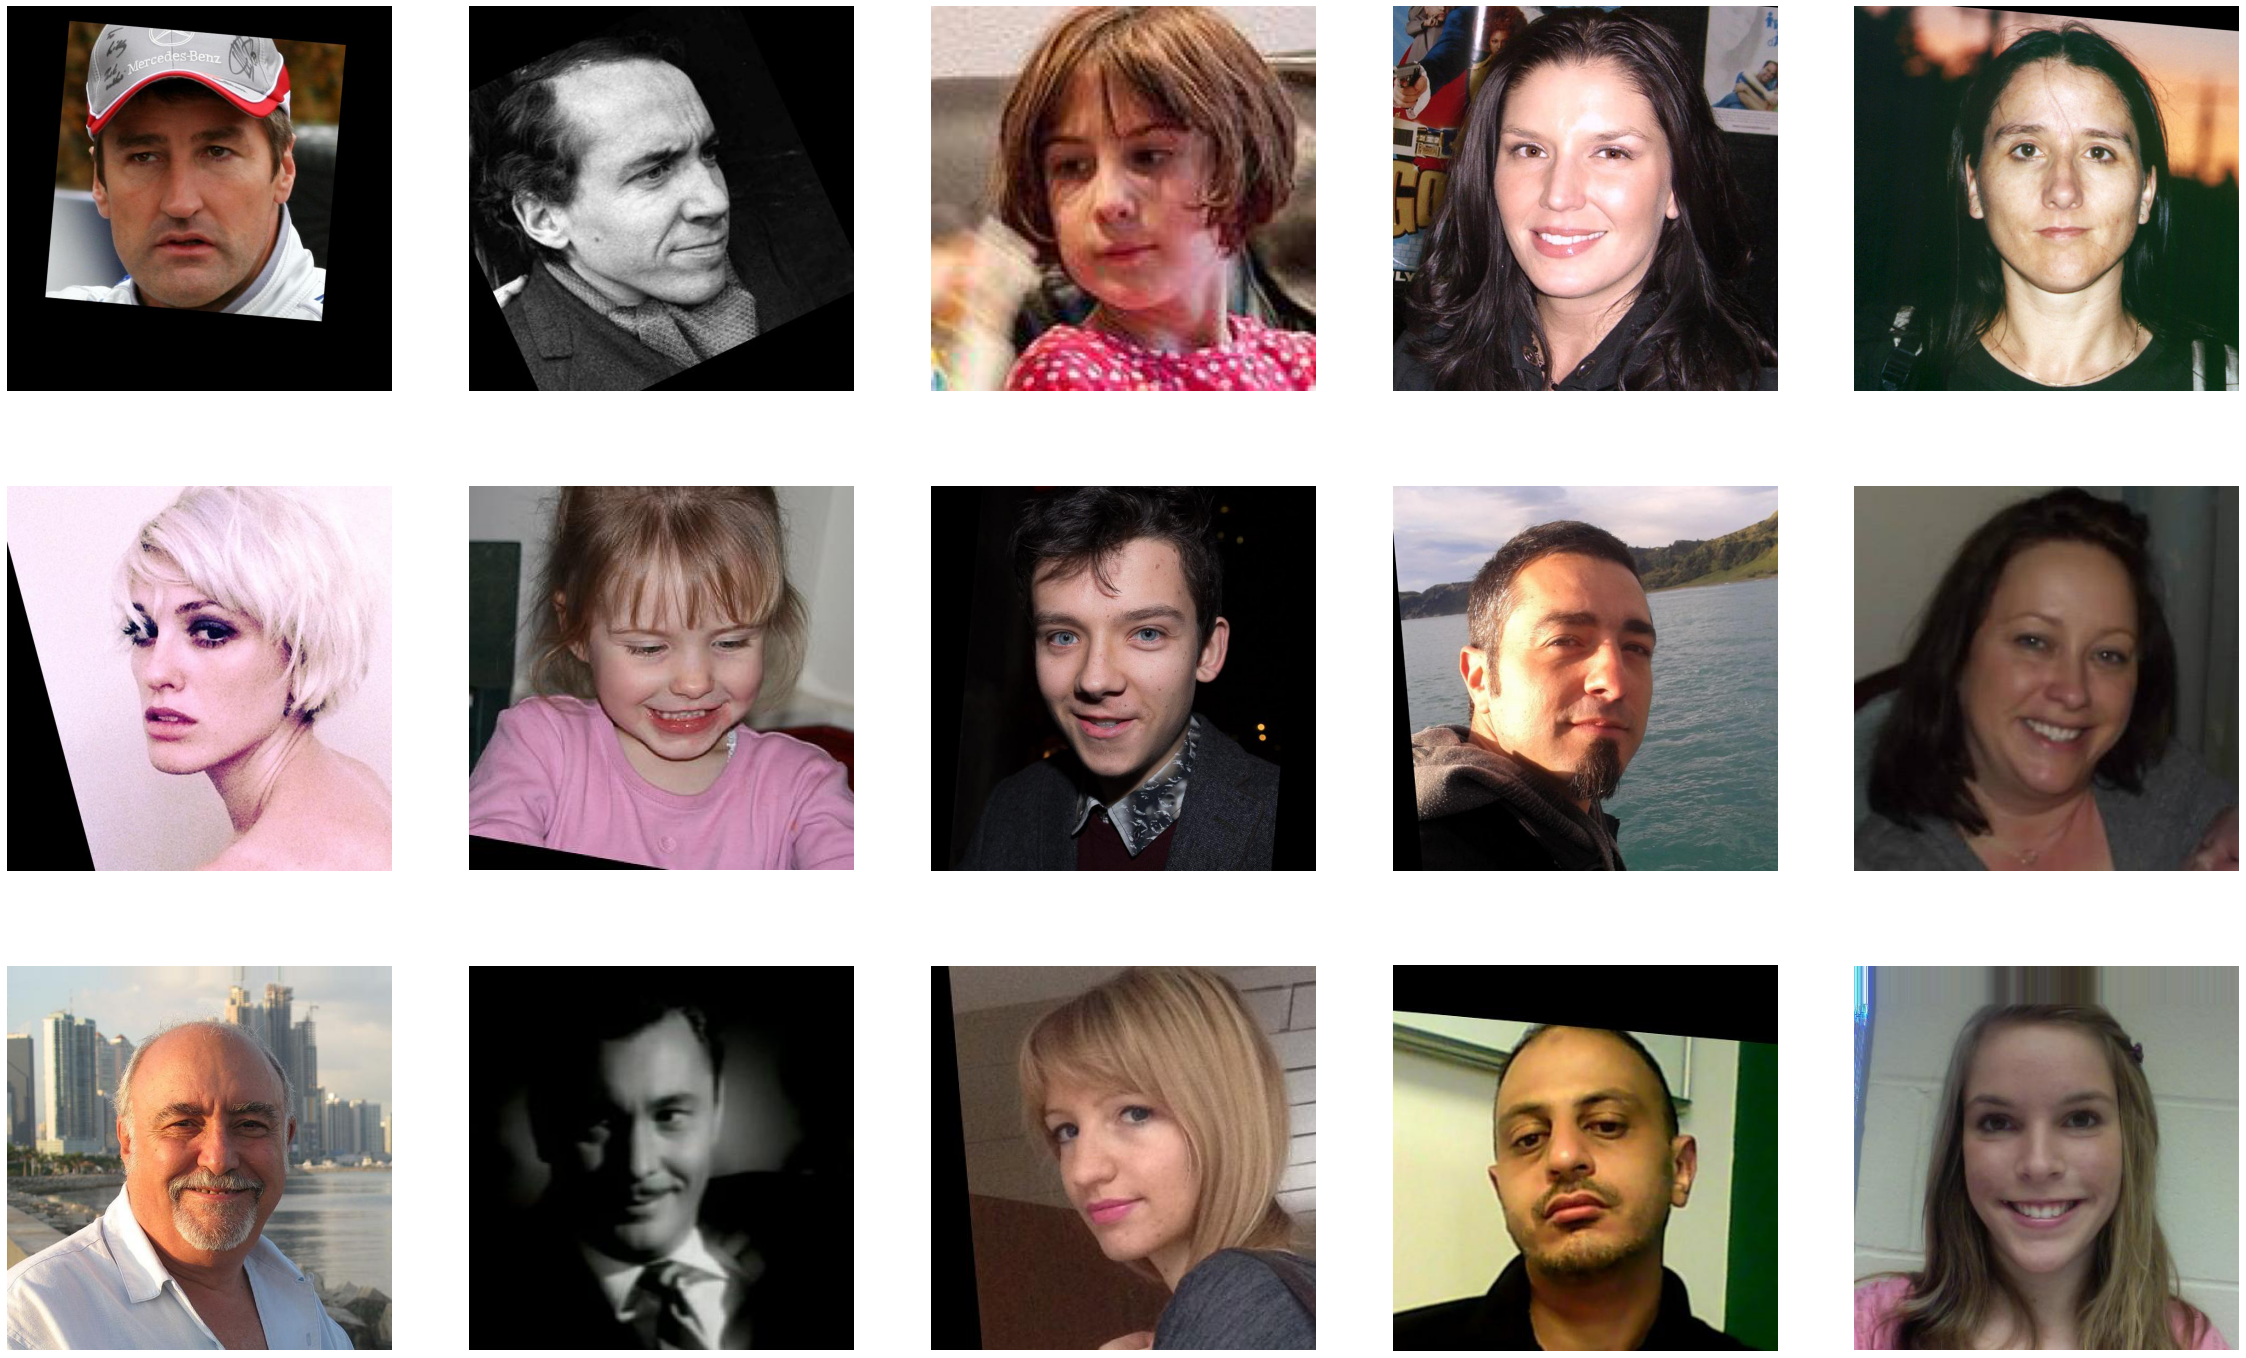

In [12]:
pic_box = plt.figure(figsize=(40,25))

for i in range(15):
    image = Image.open('/datasets/faces/final_files/'+photos[i])
    pic_box.add_subplot(3,5,i+1)
    plt.imshow(np.array(image))
    plt.axis('off')
plt.show()

Промежуточные выводы:
    1. В выборке около 8 т. элементов, большая. При построении модели нет не необходимости "заморозить" верхушку для избегания переобучения.
    2. В выборке нормальное распределение по возрастам с пиком в диапазоне 25-30 лет. 
    3. В выборке представлены все возраста с 1 до 100 лет.
    4. Наблюдаются пиковые значения на круглых годах, возможно связано с легкостью интерпретации возраста к конкретному десятку лет, без уточнения единиц года.
    5. Выборка фотографий:
        5.1. Присутсвуют мужчины и женщины,
        5.2. Люди разных национальностей,
        5.3. Фотографии цветные и черно-белые,
        5.4. Разный фон (равномерный, неравномерный, город, природа и т.д.)
        5.5. Присутсвует аугментация некоторых фотографий (смещения, повороты, уменьшение)
        5.6. Фотографии с разных сторон (спереди, сбоку, под углом)
        5.7. Разнообразный спектр эмоций на лицах всех поло-возрастных групп.

## Обучение модели

Код для обучения модели

```python


def load_test(path):
        
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
               
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),   
    
    x_col='file_name',
    y_col='real_age',   
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
    
    return test_datagen_flow

def load_train(path):
    
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
              
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory= (path + '/final_files'),
     
    x_col='file_name',
    y_col='real_age',  
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345)
    
    return train_datagen_flow


def create_model(input_shape):
  model = Sequential()
  backbone = ResNet50(input_shape =(224, 224, 3),
                  weights='imagenet', 
                  include_top=False)

  model = Sequential()
  model.add(backbone)
  model.add(GlobalAveragePooling2D())
  model.add(Dense(1, activation='relu')) 
  optimizer = Adam(lr=0.0001)
  model.compile(optimizer=optimizer, 
                loss='mse', 
                metrics=['mae'])
  return model

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              epochs=epochs,
              batch_size=batch_size, 
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат работы модели

```
Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 104s - loss: 259.2478 - mae: 11.6917 - val_loss: 907.4665 - val_mae: 25.2946
Epoch 2/6
178/178 - 95s - loss: 104.9842 - mae: 7.8024 - val_loss: 784.3816 - val_mae: 23.0490
Epoch 3/6
178/178 - 90s - loss: 83.0841 - mae: 6.8731 - val_loss: 292.7206 - val_mae: 12.5850
Epoch 4/6
178/178 - 89s - loss: 69.5036 - mae: 6.3284 - val_loss: 203.2881 - val_mae: 11.4396
Epoch 5/6
178/178 - 88s - loss: 58.1096 - mae: 5.8205 - val_loss: 106.7239 - val_mae: 7.9536
Epoch 6/6
178/178 - 88s - loss: 46.6277 - mae: 5.2201 - val_loss: 77.7688 - val_mae: 6.5923

60/60 - 9s - loss: 77.7688 - mae: 6.5923
Test MAE: 6.5923

```

## Анализ обученной модели

1. Модель построена на архитектуре ResNet50.
2. Веса модели Imagenet
3. Последние слои - GlobalAveragePooling2D и Dense.
4. Модель обучается на 6 эпохах.
5. Тестовое МАЕ = 6,6, что ниже целевой метрики МАЕ < 8